In [2]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import pybullet as p
import pybullet_data 
import time

In [3]:
physicsClient = p.connect(p.GUI)

In [4]:
p.setGravity(0,0,-10) 
p.resetSimulation() 
p.setAdditionalSearchPath(pybullet_data.getDataPath()) 
planeId = p.loadURDF("plane.urdf") 
robotId = p.loadURDF("iiwa7.urdf",flags=9, useFixedBase=1)

robotStartPos = [0,0,0]
robotStartOrientation = p.getQuaternionFromEuler([0,0,0])

p.resetBasePositionAndOrientation(robotId,robotStartPos,robotStartOrientation)

p.setJointMotorControlArray(robotId,range(7),p.VELOCITY_CONTROL,forces=np.zeros(7))

In [14]:
a=1
horizon_length = 50
Q2=0.1*np.eye(14)
Q1=1000*np.eye(14)
for i in range(7,14):
    Q1[i,i]=0.1
Q=[]
for i in range(horizon_length+1):
    if (i==horizon_length):
        Q.append(Q1)
    else:
        Q.append(Q2)

R=0.01*np.eye(7)
sigma=40
C=np.eye(14)
Sigma=1*np.eye(14)


u_bar = np.zeros([7, horizon_length])
U = np.zeros([7, horizon_length])
Z = np.zeros([14,horizon_length+1])
u= np.zeros([7, horizon_length])
    
      
z_bar=np.zeros([14,horizon_length+1])
target_p = np.array([1,0.5,1])
robotEndOrientation = p.getQuaternionFromEuler([0,0,0])
targetPositionsJoints = p.calculateInverseKinematics(robotId,7,target_p,targetOrientation = robotEndOrientation)
p.setJointMotorControlArray(robotId,range(7),p.POSITION_CONTROL,targetPositions = targetPositionsJoints)
z_bar[0:7,horizon_length]=targetPositionsJoints
#for i in range (100):
#    p.stepSimulation()
#for i in range(7):
#    z_bar[i,1000]=p.getJointStates(robotId,range(7))[i][0]
#for i in range(7):
#    z_bar[i+7,1000]=p.getJointStates(robotId,range(7))[i][1]


In [6]:
def simulate_system(x, u):
    x_next=[]
    for i in range(7):
        p.resetJointState(robotId,i,x[i],targetVelocity = x[i+7])
    
    p.setJointMotorControlArray(robotId,range(7), controlMode=p.TORQUE_CONTROL,forces=u)
    p.stepSimulation()
    for i in range(7):
        x_next.append(p.getJointStates(robotId,range(7))[i][0])
    for i in range(7):
        x_next.append(p.getJointStates(robotId,range(7))[i][1])
    x_next = np.array(x_next)
    return x_next
    
    

In [7]:
def get_linearization(current_state, control_signal):
    eps = 1e-5
    A = np.zeros([len(current_state), len(current_state)])
    for ii in range(len(current_state)):
        x = current_state.copy()
        x[ii] += eps
        x_inc = simulate_system(x, control_signal)  
        x = current_state.copy()
        x[ii] -= eps
        x_dec = simulate_system(x, control_signal)
        A[:,ii] = (x_inc - x_dec) / (2 * eps)
 
    B = np.zeros([len(current_state), len(control_signal)])
    for ii in range(len(control_signal)):
        u = control_signal.copy()
        u[ii] += eps
        x_inc = simulate_system(current_state, u)
        u = control_signal.copy()
        u[ii] -= eps
        x_dec = simulate_system(current_state, u)
        B[:,ii] = (x_inc - x_dec) / (2 * eps)
    return A, B

In [8]:
def solve_ricatti_equations(Z,U,Q,R,N,q,r):
    
    
    K_gains = []
    k_feedforward = []
    S = Q[-1]
    s = q[-1]
       
    for i in reversed(range(horizon_length)):
        A, B = get_linearization(Z[:,i], U[:,i])
        W = np.linalg.inv(Sigma)-sigma*C.T.dot(S).dot(C)
        iW = np.linalg.inv(W)
        term_covar = C.dot(iW).dot(C.T)
        H = R + B.T.dot(S).dot(B) + sigma * B.T.dot(S.T).dot(term_covar).dot(S).dot(B)
        g = r[i] + B.T.dot(s) + sigma * B.T.dot(S.T).dot(term_covar).dot(s)
        G = B.T.dot(S).dot(A) + sigma * B.T.dot(S.T).dot(term_covar.T).dot(S).dot(A)
        k = -np.linalg.solve(H,g)
        K = -np.linalg.solve(H,G)
        s = q[i] + A.T.dot(s) + G.T.dot(k) + K.T.dot(g) + K.T.dot(H).dot(k) + sigma * A.T.dot(S.T).dot(term_covar).dot(s)
        S = Q[i] + A.T.dot(S).dot(A) + K.T.dot(H).dot(K) + G.T.dot(K) + K.T.dot(G) + sigma * A.T.dot(S.T).dot(term_covar).dot(S).dot(A)
      
        K_gains.append(K)
        k_feedforward.append(k)
        
       
    K_gains = K_gains[::-1]
    k_feedforward = k_feedforward[::-1]
    return K_gains, k_feedforward

In [9]:
def controller(Z,U,q,r,horizon_length,Q,R,alpha):
    state2=np.empty([14, horizon_length+1])
    z0 = np.zeros([14,])
    state2[:,0] = z0
    u2 = np.zeros([7, horizon_length])
    K,k = solve_ricatti_equations(Z,U,Q,R,horizon_length,q,r)
    for i in range(horizon_length):
        u2[:,i] = U[:,i] + K[i] @ (state2[:,i] - Z[:,i])+ alpha*k[i]
        state2[:,i+1] = simulate_system(state2[:,i], u2[:,i])
   
   
        
    
    state=state2.copy()
    u=u2.copy()
    return state,u,k

In [10]:
def compute_cost(Z,U,z_bar,u_bar, horizon_length):
    J=((Z[:,horizon_length]-z_bar[:,horizon_length]).T)@ Q[horizon_length] @(Z[:,horizon_length]-z_bar[:,horizon_length])
    for i in range(horizon_length):
        J=J+((Z[:,i]-z_bar[:,i]).T)@ Q[i] @(Z[:,i]-z_bar[:,i])+((U[:,i]-u_bar[:,i]).T @ R @ (U[:,i]-u_bar[:,i]))
    
    return J

In [11]:
def get_quadratic_approximation_cost(Z,U, horizon_length,z_bar,u_bar):
    q=[]
    r=[]
    J=compute_cost(Z,U,z_bar,u_bar, horizon_length)
    #J=J+0.5*((z[:,horizon_length]-Z[:,horizon_length]).T)@ Q[horizon_length] @(z[:,horizon_length]-Z[:,horizon_length])+2*(z[:,horizon_length].T-z_bar[:,horizon_length].T)@Q[horizon_length]@(z[:,horizon_length]-Z[:,horizon_length])
    for i in range(horizon_length):
        #J=J+0.5*((u[:,i]-U[:,i]).T)@ R @(u[:,i]-U[:,i])+0.5*((z[:,i]-Z[:,i]).T)@ Q[i] @(z[:,i]-Z[:,i])+2*((z[:,i]-z_bar[:,i]).T)@Q[i]@(z[:,i]-Z[:,i])+2*((u[:,i]-u_bar[:,i]).T)@R@(u[:,i]-U[:,i])    
        q1=2*(Z[:,i]-z_bar[:,i]).T@Q[i]
        q.append(q1)
        r1=2*(U[:,i]-u_bar[:,i]).T@R
        r.append(r1)
    
    return q,r

In [15]:
q,r=get_quadratic_approximation_cost(Z,U, horizon_length,z_bar,u_bar)
state,u,k = controller(Z,U,q,r,horizon_length,Q,R,a)
U = u
Z = np.zeros([14, horizon_length+1])
for i in range(horizon_length):
    Z[:,i+1] = simulate_system(Z[:,i], U[:,i])
J=compute_cost(Z,U,z_bar,u_bar, horizon_length)
J1=J
print(J)

for j in range(300):
    q,r=get_quadratic_approximation_cost(Z,U, horizon_length,z_bar,u_bar)
    state,u,k = controller(Z,U,q,r,horizon_length,Q,R,a)
    U = u
    Z = np.zeros([14, horizon_length+1])
    for i in range(horizon_length):
        Z[:,i+1] = simulate_system(Z[:,i], U[:,i])
    J=compute_cost(Z,U,z_bar,u_bar, horizon_length)
    print(J)
    if (J<=J1):
        if (abs(J1-J)<1e-14):
            print("iteration converged")
            break
        J1=J
    else:
        a=a/2
        J1=J
        print(a)

793.7078995708978
793.7078994591495
793.7078995709027
0.5
793.7078976617447
793.7078976617483
0.25
793.707897661744
793.7078976617424
793.7078976617472
0.125
793.7078976617458
793.7078976617447
793.707897661744
793.7078976617452
0.0625
793.707897661745
793.7078976617454
0.03125
793.7078976617457
0.015625
793.7078976617456
793.7078976617456
iteration converged


In [13]:
g1=np.array(k)

In [16]:
g2=np.array(k)

<IPython.core.display.Javascript object>


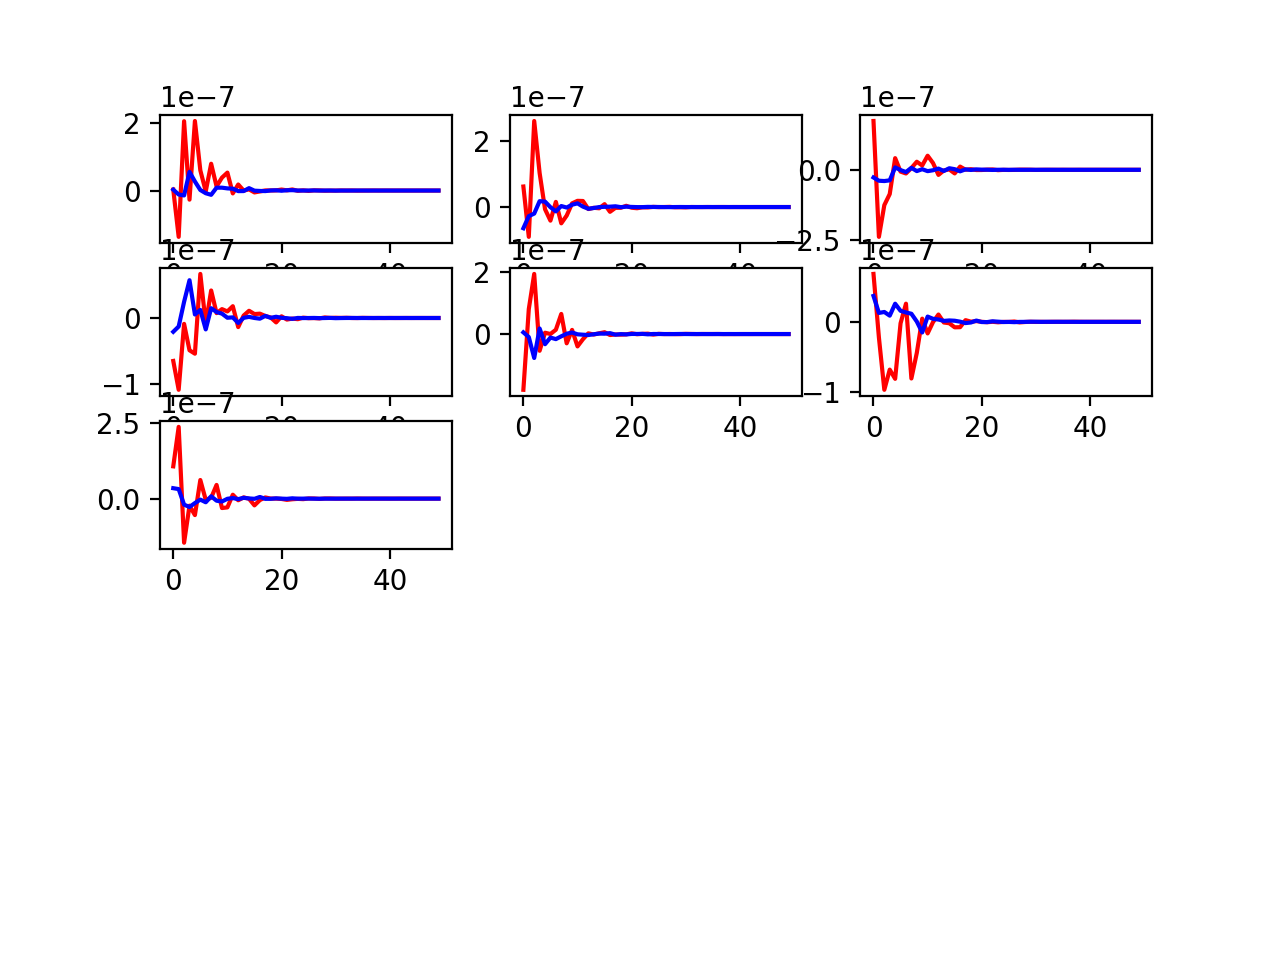

In [17]:
n= [i for i in range(horizon_length)]
plt.figure()
plt.subplot(5,3,1)
plt.plot(n,g1[:,0],'r',n,g2[:,0],'b')
plt.subplot(5,3,2)
plt.plot(n,g1[:,1],'r',n,g2[:,1],'b')
plt.subplot(5,3,3)
plt.plot(n,g1[:,2],'r',n,g2[:,2],'b')
plt.subplot(5,3,4)
plt.plot(n,g1[:,3],'r',n,g2[:,3],'b')
plt.subplot(5,3,5)
plt.plot(n,g1[:,4],'r',n,g2[:,4],'b')
plt.subplot(5,3,6)
plt.plot(n,g1[:,5],'r',n,g2[:,5],'b')
plt.subplot(5,3,7)
plt.plot(n,g1[:,6],'r',n,g2[:,6],'b')
# plt.subplot(5,3,8)
# plt.plot(n,g1[7,:],'o',n,g2[7,:],'^')
# plt.subplot(5,3,9)
# plt.plot(n,g1[8,:],'o',n,g2[8,:],'^')
# plt.subplot(5,3,10)
# plt.plot(n,g1[9,:],'o',n,g2[9,:],'^')
# plt.subplot(5,3,11)
# plt.plot(n,g1[10,:],'o',n,g2[10,:],'^')
# plt.subplot(5,3,12)
# plt.plot(n,g1[11,:],'o',n,g2[11,:],'^')
# plt.subplot(5,3,13)
# plt.plot(n,g1[12,:],'o',n,g2[12,:],'^')
# plt.subplot(5,3,14)
# plt.plot(n,g1[13,:],'o',n,g2[13,:],'^')
# plt.title('loss function value')

In [14]:
x = np.zeros([14,1])
for i in range(7):
    p.resetJointState(robotId,i,x[i],targetVelocity = x[i+7])

In [15]:
xe=[]
for i in range(horizon_length):
    p.setJointMotorControlArray(robotId,range(7), controlMode=p.TORQUE_CONTROL,forces= u[:,i])
    xe.append(p.getLinkState(robotId,7)[0])
    p.stepSimulation()
print(xe)

[(0.09999999999999991, 1.8041124150158794e-16, 1.196), (0.09999999999999991, 1.8041124150158794e-16, 1.196), (0.1808701057184943, 0.004134683671038867, 1.191913948110837), (0.2550119922437946, 0.01502244394258537, 1.18084004382647), (0.3198262085836223, 0.03044053619294872, 1.164947685414933), (0.37587850110618454, 0.04863632514419368, 1.1459513907156826), (0.4240124548175081, 0.06828971586241121, 1.1251519774368437), (0.4651413243461954, 0.08843761462243843, 1.103520297192805), (0.5001657760534532, 0.10840100620633016, 1.0817659468190823), (0.529928347699666, 0.12772003225643486, 1.0603948622936663), (0.5551909324800274, 0.14609963807031004, 1.0397563967019523), (0.5766267820828526, 0.16336590819668687, 1.0200810230216153), (0.5948212160834423, 0.17943201041684617, 1.0015100729563957), (0.6102771824201044, 0.19427222929552088, 0.9841189175899921), (0.6234231935841882, 0.20790253254379015, 0.9679348603111375), (0.6346221059474959, 0.22036626260064943, 0.9529508304500681), (0.6441798372